# MlFlow Experiment Tracking Setup

In [34]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Transfer Learning Practice")
mlflow.set_tag("mlflow.runName", "inital run")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [55]:
import os
import cv2
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DATA_DIR = './data'
TRANSLATED_DATA_DIR = './data_translated'

In [2]:
import torch
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [35]:
CLASSIFICATION_MAPPING = {"athletic" : 0, "baggy" : 1, "old_money" : 2, "skinny" : 3}

In [4]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
data, labels = [], []
for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)
        print(img_rgb)
        print("--------------------------------------------------------")
        print(img_pil)

        data.append(image_tensor)
        labels.append(dir_)
        # Reconverting the image to view in data_translated
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)

        # Convert to PIL and save
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

[[[11  9 10]
  [10  8  9]
  [10  8  9]
  ...
  [14 10  9]
  [14 10  9]
  [14 10  9]]

 [[10  8  9]
  [10  8  9]
  [10  8  9]
  ...
  [14 10  9]
  [14 10  9]
  [14 10  9]]

 [[10  8  9]
  [10  8  9]
  [ 9  7  8]
  ...
  [14 10  9]
  [14 10  9]
  [14 10  9]]

 ...

 [[38 19 12]
  [38 19 12]
  [38 19 12]
  ...
  [35 51 76]
  [35 51 74]
  [35 51 74]]

 [[37 18 11]
  [37 18 11]
  [37 18 11]
  ...
  [34 50 75]
  [34 50 73]
  [34 50 73]]

 [[38 19 12]
  [38 19 12]
  [38 19 12]
  ...
  [34 50 75]
  [34 50 73]
  [34 50 73]]]
--------------------------------------------------------
<PIL.Image.Image image mode=RGB size=736x981 at 0x2354595C250>
[[[ 56  57  61]
  [ 55  56  60]
  [ 52  53  57]
  ...
  [ 71  75  74]
  [ 70  74  73]
  [ 70  74  73]]

 [[ 52  53  57]
  [ 52  53  57]
  [ 52  53  57]
  ...
  [ 72  76  75]
  [ 72  76  75]
  [ 73  77  76]]

 [[ 47  48  52]
  [ 49  50  54]
  [ 52  53  57]
  ...
  [ 73  77  76]
  [ 73  77  76]
  [ 74  78  77]]

 ...

 [[174 188 201]
  [174 188 201]
  [174 1

In [28]:
print(len(data))

175


In [37]:
from torch.utils.data import Dataset, DataLoader, random_split

class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [38]:
dataset = SignDataset(data, labels)
len(dataset)

175

In [39]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

140
35


In [44]:
train_dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 14, shuffle = True)

In [45]:
for data, label in train_dataloader:
    break

In [46]:
print(data.shape)

torch.Size([32, 3, 224, 224])


In [47]:
print(label.shape)

torch.Size([32])


# Loading Pre-trained Model from Pytorch

In [48]:
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(pretrained=True)
num_classes = 4 # Change output to 4 for desired classification task
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Phuong Hoang Dinh\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
for param in model.parameters():
 param.requires_grad = False
# Unfreeze the last layer
for param in model.fc.parameters():
 param.requires_grad = True

In [50]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model training

In [53]:
num_epochs = 400
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for image, labels in tqdm(train_dataloader, desc = "Training loop"):
        image, labels = image.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for image, labels in tqdm(test_dataloader, desc = "Validation loop"):
            image, labels = image.to(DEVICE), labels.to(DEVICE)
            outputs = model(image)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 400 - Train loss: 1.3567030470711845 , Validation loss: 1.0938954591751098


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 400 - Train loss: 1.03343405519213 , Validation loss: 0.8412655711174011


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 400 - Train loss: 0.8569810342788696 , Validation loss: 0.6882046103477478


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 400 - Train loss: 0.7743395171846662 , Validation loss: 0.567135214805603


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 400 - Train loss: 0.6154296929495675 , Validation loss: 0.5595470190048217


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 400 - Train loss: 0.5697988029888698 , Validation loss: 0.4722225606441498


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 400 - Train loss: 0.4684904497010367 , Validation loss: 0.393649035692215


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 400 - Train loss: 0.4438465651444026 , Validation loss: 0.38982430696487425


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 400 - Train loss: 0.3957753896713257 , Validation loss: 0.3217902898788452


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 400 - Train loss: 0.3320578386102404 , Validation loss: 0.3040103852748871


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 400 - Train loss: 0.3340239684922355 , Validation loss: 0.2704656094312668


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 400 - Train loss: 0.3290996958528246 , Validation loss: 0.2645417213439941


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 400 - Train loss: 0.2850672675882067 , Validation loss: 0.2435286521911621


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 400 - Train loss: 0.2968491218771253 , Validation loss: 0.2243490159511566


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 400 - Train loss: 0.2652794482026781 , Validation loss: 0.21479940712451934


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 400 - Train loss: 0.23589649541037425 , Validation loss: 0.20144432485103608


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 400 - Train loss: 0.24569380521774292 , Validation loss: 0.17421778663992882


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 400 - Train loss: 0.2280189493724278 , Validation loss: 0.18462723195552827


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 400 - Train loss: 0.20925058901309967 , Validation loss: 0.16735572516918182


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 400 - Train loss: 0.19147148183413915 , Validation loss: 0.14356117844581603


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 400 - Train loss: 0.18267325690814426 , Validation loss: 0.14230176210403442


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 400 - Train loss: 0.19154261801924025 , Validation loss: 0.1490464761853218


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 400 - Train loss: 0.1663829801763807 , Validation loss: 0.1252387672662735


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 400 - Train loss: 0.14614547218595234 , Validation loss: 0.12513915747404097


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 400 - Train loss: 0.1855743968486786 , Validation loss: 0.1113852933049202


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 400 - Train loss: 0.1896648849759783 , Validation loss: 0.11927593052387238


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 400 - Train loss: 0.1675378769636154 , Validation loss: 0.11967312097549439


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 400 - Train loss: 0.17821044402463096 , Validation loss: 0.09755541682243347


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 400 - Train loss: 0.14277256109884806 , Validation loss: 0.0856972575187683


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 400 - Train loss: 0.15023662533078874 , Validation loss: 0.10338945388793945


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 400 - Train loss: 0.13510700106620788 , Validation loss: 0.09312333464622498


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 400 - Train loss: 0.15050575750214712 , Validation loss: 0.091435307264328


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 400 - Train loss: 0.1119679855448859 , Validation loss: 0.08015196472406387


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 400 - Train loss: 0.12602410597460612 , Validation loss: 0.08192578703165054


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 400 - Train loss: 0.1022399491071701 , Validation loss: 0.07125725448131562


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 400 - Train loss: 0.10828491389751434 , Validation loss: 0.07633544951677322


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 400 - Train loss: 0.09072209311383111 , Validation loss: 0.06516814529895783


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 400 - Train loss: 0.10475826697690147 , Validation loss: 0.0577860102057457


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 400 - Train loss: 0.08777737074664661 , Validation loss: 0.06136440485715866


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 400 - Train loss: 0.08882776588201523 , Validation loss: 0.06376228034496308


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 400 - Train loss: 0.0875301730632782 , Validation loss: 0.059737271070480345


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 400 - Train loss: 0.08293643195714269 , Validation loss: 0.04956158101558685


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 400 - Train loss: 0.10691734458718981 , Validation loss: 0.05669735670089722


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 400 - Train loss: 0.06698667394263404 , Validation loss: 0.057552476227283475


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 400 - Train loss: 0.08230120924966676 , Validation loss: 0.05162591487169266


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 400 - Train loss: 0.07064783296414784 , Validation loss: 0.04547567218542099


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 400 - Train loss: 0.07391486644744873 , Validation loss: 0.04484869763255119


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 400 - Train loss: 0.061557585852486746 , Validation loss: 0.05033597573637962


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 400 - Train loss: 0.08317338986056191 , Validation loss: 0.0473569817841053


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 400 - Train loss: 0.07005828487021583 , Validation loss: 0.047962430864572525


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 400 - Train loss: 0.07357093840837478 , Validation loss: 0.04038010165095329


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 400 - Train loss: 0.07826644133244241 , Validation loss: 0.036843223869800566


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 400 - Train loss: 0.07371082408087594 , Validation loss: 0.039557934552431104


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 400 - Train loss: 0.07628357997962407 , Validation loss: 0.036212701350450516


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 400 - Train loss: 0.07456740247351783 , Validation loss: 0.04141619205474854


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 400 - Train loss: 0.07940562678234918 , Validation loss: 0.042495092004537584


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 400 - Train loss: 0.06545114823750087 , Validation loss: 0.04220001474022865


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 400 - Train loss: 0.09177506719316755 , Validation loss: 0.034425949305295946


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 400 - Train loss: 0.07550601929426193 , Validation loss: 0.0428164005279541


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 400 - Train loss: 0.07385569378733635 , Validation loss: 0.03522418513894081


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 400 - Train loss: 0.060815989715712414 , Validation loss: 0.042186378687620166


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 400 - Train loss: 0.04818746098450252 , Validation loss: 0.03367577195167541


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 400 - Train loss: 0.05698340748037611 , Validation loss: 0.029070917516946793


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 400 - Train loss: 0.052598674425057 , Validation loss: 0.0276728767901659


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 400 - Train loss: 0.04976329624652862 , Validation loss: 0.032237850874662397


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 400 - Train loss: 0.041992982434374944 , Validation loss: 0.03304576799273491


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 400 - Train loss: 0.055046677121094297 , Validation loss: 0.027296613529324533


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 400 - Train loss: 0.048208939560822076 , Validation loss: 0.028594305366277696


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 400 - Train loss: 0.05604728292141642 , Validation loss: 0.024630460515618326


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 400 - Train loss: 0.04429830572434834 , Validation loss: 0.024982057884335516


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 400 - Train loss: 0.04098749912210873 , Validation loss: 0.025818738713860513


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 400 - Train loss: 0.05220417772020612 , Validation loss: 0.026831748709082604


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 400 - Train loss: 0.044564109104020255 , Validation loss: 0.023149815574288368


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 400 - Train loss: 0.046278985738754275 , Validation loss: 0.023450255021452905


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 400 - Train loss: 0.03959399302090917 , Validation loss: 0.021822164580225945


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 400 - Train loss: 0.036483663001230786 , Validation loss: 0.020859283208847047


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 400 - Train loss: 0.040224343155111586 , Validation loss: 0.023126416280865668


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 400 - Train loss: 0.0416247256738799 , Validation loss: 0.028305383026599885


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 400 - Train loss: 0.04461760078157698 , Validation loss: 0.021010945178568365


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 400 - Train loss: 0.04225917228630611 , Validation loss: 0.02044042758643627


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 400 - Train loss: 0.03576037487813405 , Validation loss: 0.020836954563856126


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 400 - Train loss: 0.04415005485926356 , Validation loss: 0.020789311826229097


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 400 - Train loss: 0.044674708502633234 , Validation loss: 0.01998218446969986


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 400 - Train loss: 0.06475767962634564 , Validation loss: 0.018617544323205948


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 400 - Train loss: 0.04025643851075854 , Validation loss: 0.017376106604933737


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 400 - Train loss: 0.044065427354403906 , Validation loss: 0.018924150615930557


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 400 - Train loss: 0.04419433781078884 , Validation loss: 0.019868335500359536


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 400 - Train loss: 0.03957473627158574 , Validation loss: 0.02054814249277115


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 400 - Train loss: 0.03299758513058935 , Validation loss: 0.0180401973426342


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 400 - Train loss: 0.04475024206297738 , Validation loss: 0.018380382657051088


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 400 - Train loss: 0.028261550196579523 , Validation loss: 0.018633114546537398


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 400 - Train loss: 0.03191047034093312 , Validation loss: 0.017043032497167588


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 400 - Train loss: 0.031957073105233054 , Validation loss: 0.017385981604456903


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 400 - Train loss: 0.04039229580334255 , Validation loss: 0.01754714362323284


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 400 - Train loss: 0.03156904001321111 , Validation loss: 0.016027007438242435


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 400 - Train loss: 0.036025288296597346 , Validation loss: 0.014158861339092254


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 400 - Train loss: 0.04041859584195273 , Validation loss: 0.01714361347258091


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 400 - Train loss: 0.04149125326957021 , Validation loss: 0.02122751958668232


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 400 - Train loss: 0.02842875423175948 , Validation loss: 0.01712940223515034


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 400 - Train loss: 0.025682603578482354 , Validation loss: 0.014637406542897224


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 out of 400 - Train loss: 0.03678858446223395 , Validation loss: 0.013374583423137664


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 out of 400 - Train loss: 0.0328505242722375 , Validation loss: 0.015019108075648546


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 out of 400 - Train loss: 0.03542177660124642 , Validation loss: 0.015812904015183447


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 out of 400 - Train loss: 0.029085577790226254 , Validation loss: 0.01416845889762044


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 out of 400 - Train loss: 0.036545556783676145 , Validation loss: 0.01669750679284334


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 out of 400 - Train loss: 0.042636488271611074 , Validation loss: 0.015532772615551948


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 out of 400 - Train loss: 0.023399937312517848 , Validation loss: 0.012067169696092606


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 out of 400 - Train loss: 0.04343875349632331 , Validation loss: 0.011054915841668844


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 out of 400 - Train loss: 0.032245971177305495 , Validation loss: 0.010851612873375415


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 out of 400 - Train loss: 0.020195360705256463 , Validation loss: 0.012270011566579342


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 out of 400 - Train loss: 0.023402739997420992 , Validation loss: 0.011494078487157822


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 out of 400 - Train loss: 0.01785946398973465 , Validation loss: 0.012921887636184692


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 out of 400 - Train loss: 0.03285242668219975 , Validation loss: 0.012812024354934693


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 out of 400 - Train loss: 0.02548947538648333 , Validation loss: 0.009785258583724499


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 out of 400 - Train loss: 0.02486062807696206 , Validation loss: 0.010687796398997307


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 out of 400 - Train loss: 0.02253621586731502 , Validation loss: 0.010130065493285656


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 out of 400 - Train loss: 0.022711124611752374 , Validation loss: 0.009953971207141876


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 out of 400 - Train loss: 0.02102633542248181 , Validation loss: 0.010021030902862549


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 out of 400 - Train loss: 0.025782723341669356 , Validation loss: 0.009832921624183654


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 out of 400 - Train loss: 0.01887767317039626 , Validation loss: 0.010911167785525321


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 out of 400 - Train loss: 0.03112956328051431 , Validation loss: 0.010944541171193123


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 out of 400 - Train loss: 0.021365111310567175 , Validation loss: 0.0127433430403471


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 out of 400 - Train loss: 0.02554997639996665 , Validation loss: 0.010219753440469503


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 out of 400 - Train loss: 0.0181186826686774 , Validation loss: 0.008625700976699591


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 out of 400 - Train loss: 0.02513797426330192 , Validation loss: 0.009396936930716037


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 out of 400 - Train loss: 0.0166771100461483 , Validation loss: 0.00946565717458725


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 out of 400 - Train loss: 0.023945332041808536 , Validation loss: 0.008963419403880835


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 out of 400 - Train loss: 0.019251652189663477 , Validation loss: 0.009768071537837385


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 out of 400 - Train loss: 0.02125804572233132 , Validation loss: 0.00916772373020649


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 out of 400 - Train loss: 0.019435344263911247 , Validation loss: 0.008720636600628495


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 out of 400 - Train loss: 0.023779682282890593 , Validation loss: 0.00824220348149538


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 out of 400 - Train loss: 0.030015862200941358 , Validation loss: 0.010005011782050132


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 out of 400 - Train loss: 0.024774872405188424 , Validation loss: 0.008705851994454861


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 out of 400 - Train loss: 0.02011949075119836 , Validation loss: 0.010726828314363956


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 out of 400 - Train loss: 0.018100680825965745 , Validation loss: 0.009966842923313379


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 out of 400 - Train loss: 0.01717184528708458 , Validation loss: 0.008633316215127706


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 out of 400 - Train loss: 0.017549512535333635 , Validation loss: 0.007759708352386952


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 out of 400 - Train loss: 0.01655125642461436 , Validation loss: 0.007528277579694986


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 out of 400 - Train loss: 0.02555713585444859 , Validation loss: 0.00785458656027913


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 out of 400 - Train loss: 0.02271925781454359 , Validation loss: 0.008382148388773204


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 out of 400 - Train loss: 0.01662096867603915 , Validation loss: 0.010168112255632878


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 out of 400 - Train loss: 0.025486336568636553 , Validation loss: 0.0083506322465837


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 out of 400 - Train loss: 0.016429851268018995 , Validation loss: 0.006943219155073166


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 out of 400 - Train loss: 0.019888401925563813 , Validation loss: 0.010318551771342754


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 out of 400 - Train loss: 0.01901652771447386 , Validation loss: 0.007603388279676437


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 out of 400 - Train loss: 0.017300444543361663 , Validation loss: 0.007903528772294522


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 out of 400 - Train loss: 0.01791923122746604 , Validation loss: 0.0074660713784396645


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 out of 400 - Train loss: 0.052832122530256 , Validation loss: 0.0070579185150563715


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 out of 400 - Train loss: 0.02957898781235729 , Validation loss: 0.021270446851849555


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 out of 400 - Train loss: 0.048203141401921 , Validation loss: 0.007071328395977616


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 out of 400 - Train loss: 0.01462220583643232 , Validation loss: 0.011120348051190377


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 out of 400 - Train loss: 0.019282149193542344 , Validation loss: 0.011689552292227744


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 out of 400 - Train loss: 0.0224833259837968 , Validation loss: 0.008055720292031766


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 out of 400 - Train loss: 0.014127438600574221 , Validation loss: 0.006556846760213375


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 out of 400 - Train loss: 0.016568926881466592 , Validation loss: 0.008386653754860163


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 out of 400 - Train loss: 0.01816432963524546 , Validation loss: 0.006486892327666282


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 out of 400 - Train loss: 0.012400270838822638 , Validation loss: 0.006167364865541458


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 out of 400 - Train loss: 0.014032191346798624 , Validation loss: 0.005780037865042687


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 out of 400 - Train loss: 0.015163413328783853 , Validation loss: 0.006197465397417545


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 out of 400 - Train loss: 0.019411826676556044 , Validation loss: 0.006768876127898693


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 out of 400 - Train loss: 0.03881190274442945 , Validation loss: 0.006566564878448844


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 out of 400 - Train loss: 0.03053882739373616 , Validation loss: 0.011606564931571483


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 out of 400 - Train loss: 0.028555811952267373 , Validation loss: 0.005930652189999819


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 out of 400 - Train loss: 0.015569714781429086 , Validation loss: 0.006677000317722559


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 out of 400 - Train loss: 0.015660922370318856 , Validation loss: 0.006676993798464537


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 out of 400 - Train loss: 0.013640794456005096 , Validation loss: 0.005991569347679615


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 out of 400 - Train loss: 0.015349207126668521 , Validation loss: 0.0059225749224424366


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 out of 400 - Train loss: 0.01140018993722541 , Validation loss: 0.005741473659873009


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 out of 400 - Train loss: 0.012255764401384763 , Validation loss: 0.0058464617002755405


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 out of 400 - Train loss: 0.012103736911501203 , Validation loss: 0.005405872268602252


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 out of 400 - Train loss: 0.020103691007409778 , Validation loss: 0.00525068873539567


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 out of 400 - Train loss: 0.02492478013038635 , Validation loss: 0.006112097715958953


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 out of 400 - Train loss: 0.02446163432938712 , Validation loss: 0.0048107137903571125


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 out of 400 - Train loss: 0.014860863046986717 , Validation loss: 0.005780405923724174


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 out of 400 - Train loss: 0.01460260712674686 , Validation loss: 0.01025587748736143


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 out of 400 - Train loss: 0.015548620325114046 , Validation loss: 0.006416100822389126


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 out of 400 - Train loss: 0.014461218650851931 , Validation loss: 0.005015703476965427


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 out of 400 - Train loss: 0.02137272615517889 , Validation loss: 0.004814848676323891


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 out of 400 - Train loss: 0.01953350529074669 , Validation loss: 0.005115913599729538


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 out of 400 - Train loss: 0.011594681588134596 , Validation loss: 0.0048893698491156105


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 out of 400 - Train loss: 0.018070806648050036 , Validation loss: 0.006615413445979356


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 out of 400 - Train loss: 0.011057542173990182 , Validation loss: 0.004280749056488275


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 out of 400 - Train loss: 0.013020510849143777 , Validation loss: 0.004470136575400829


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 out of 400 - Train loss: 0.013754324497921126 , Validation loss: 0.004444537591189146


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 out of 400 - Train loss: 0.012474845123610327 , Validation loss: 0.004617259372025728


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 out of 400 - Train loss: 0.009595337861350604 , Validation loss: 0.004228532593697309


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 out of 400 - Train loss: 0.009546196152056966 , Validation loss: 0.0042342874221503735


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 out of 400 - Train loss: 0.008888939273144518 , Validation loss: 0.003961973683908581


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 out of 400 - Train loss: 0.018253296954291207 , Validation loss: 0.003944362141191959


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 out of 400 - Train loss: 0.00848533569169896 , Validation loss: 0.0038453680463135242


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 out of 400 - Train loss: 0.01713177502155304 , Validation loss: 0.003946202574297786


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 out of 400 - Train loss: 0.01491324667419706 , Validation loss: 0.004429401829838753


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 out of 400 - Train loss: 0.013904793762734959 , Validation loss: 0.004532674979418516


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 out of 400 - Train loss: 0.01084695966648204 , Validation loss: 0.004056392889469862


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 out of 400 - Train loss: 0.016054902034146445 , Validation loss: 0.003933938825502992


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 out of 400 - Train loss: 0.01316666447690555 , Validation loss: 0.004423055797815323


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 out of 400 - Train loss: 0.024033658334187098 , Validation loss: 0.003938577463850379


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 out of 400 - Train loss: 0.013113617002964019 , Validation loss: 0.0037441679276525976


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 out of 400 - Train loss: 0.015216126229081835 , Validation loss: 0.003434199746698141


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 out of 400 - Train loss: 0.010087159797549247 , Validation loss: 0.005080363480374217


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 out of 400 - Train loss: 0.019856994354299138 , Validation loss: 0.004509481973946095


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 out of 400 - Train loss: 0.013291717107806886 , Validation loss: 0.004142266185954213


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 out of 400 - Train loss: 0.009515834631664413 , Validation loss: 0.005079698469489813


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 out of 400 - Train loss: 0.009264129900506565 , Validation loss: 0.004186726361513138


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 out of 400 - Train loss: 0.007855676087949957 , Validation loss: 0.0036553630605340006


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 out of 400 - Train loss: 0.009130926983697074 , Validation loss: 0.0036920242942869662


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 out of 400 - Train loss: 0.01660574223314013 , Validation loss: 0.003577778767794371


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 out of 400 - Train loss: 0.00722229216247797 , Validation loss: 0.004181614331901074


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 out of 400 - Train loss: 0.013273535413401467 , Validation loss: 0.004612098634243012


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 out of 400 - Train loss: 0.016083588951400347 , Validation loss: 0.0038385368883609773


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 out of 400 - Train loss: 0.015418167460177625 , Validation loss: 0.004002106306143105


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 out of 400 - Train loss: 0.011776013672351838 , Validation loss: 0.003522808151319623


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 out of 400 - Train loss: 0.008462481764810426 , Validation loss: 0.0045819365419447425


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 out of 400 - Train loss: 0.009047405368515423 , Validation loss: 0.004168345453217625


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 out of 400 - Train loss: 0.011877706072160175 , Validation loss: 0.0034225777722895145


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 out of 400 - Train loss: 0.007761288146887506 , Validation loss: 0.0033044231124222277


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217 out of 400 - Train loss: 0.010550557492034776 , Validation loss: 0.00323485741391778


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 out of 400 - Train loss: 0.008439787589013576 , Validation loss: 0.003102890681475401


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 out of 400 - Train loss: 0.006318491761173521 , Validation loss: 0.002901803655549884


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 out of 400 - Train loss: 0.011655665468424559 , Validation loss: 0.0030581096652895212


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 out of 400 - Train loss: 0.011269991951329368 , Validation loss: 0.0031350338365882637


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 out of 400 - Train loss: 0.006746967977711133 , Validation loss: 0.0028552318923175334


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 out of 400 - Train loss: 0.007434739800436156 , Validation loss: 0.002849723747931421


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 out of 400 - Train loss: 0.010365040254380021 , Validation loss: 0.0027355737518519165


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 out of 400 - Train loss: 0.01270607584289142 , Validation loss: 0.002747659990563989


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 out of 400 - Train loss: 0.011171387104051455 , Validation loss: 0.0035189988557249308


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 out of 400 - Train loss: 0.011336137769477709 , Validation loss: 0.0034184698248282074


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 out of 400 - Train loss: 0.008260043880769185 , Validation loss: 0.0032527509145438673


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 out of 400 - Train loss: 0.008958132224423545 , Validation loss: 0.003128418093547225


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 out of 400 - Train loss: 0.0058903455148850165 , Validation loss: 0.003298282390460372


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 out of 400 - Train loss: 0.009201127407806261 , Validation loss: 0.0034469416365027427


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 out of 400 - Train loss: 0.006407946606299707 , Validation loss: 0.003179542999714613


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 out of 400 - Train loss: 0.008051042700452465 , Validation loss: 0.0030992318876087665


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 out of 400 - Train loss: 0.00952776544860431 , Validation loss: 0.0029477250296622514


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 out of 400 - Train loss: 0.010312383121677808 , Validation loss: 0.0028441894333809613


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 out of 400 - Train loss: 0.008971681062664305 , Validation loss: 0.002988675143569708


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 out of 400 - Train loss: 0.005099818264799458 , Validation loss: 0.00325843570753932


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 out of 400 - Train loss: 0.00807466320959585 , Validation loss: 0.0030962998047471047


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 out of 400 - Train loss: 0.006446229155574526 , Validation loss: 0.0030333857983350756


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 out of 400 - Train loss: 0.006035017977867808 , Validation loss: 0.0024896275252103807


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 out of 400 - Train loss: 0.009247574721063887 , Validation loss: 0.002593432553112507


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 out of 400 - Train loss: 0.00929726435669831 , Validation loss: 0.0023348436690866945


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243 out of 400 - Train loss: 0.021771626259599414 , Validation loss: 0.00257662869989872


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 out of 400 - Train loss: 0.012315812307809081 , Validation loss: 0.017345844581723214


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 out of 400 - Train loss: 0.036907838540417806 , Validation loss: 0.003580094687640667


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 out of 400 - Train loss: 0.007990235425531865 , Validation loss: 0.003007623041048646


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 out of 400 - Train loss: 0.007390640040061304 , Validation loss: 0.0025280247908085586


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 out of 400 - Train loss: 0.016378529710429055 , Validation loss: 0.002437925711274147


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 out of 400 - Train loss: 0.0129542777421219 , Validation loss: 0.005722858477383852


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250 out of 400 - Train loss: 0.017767464348248073 , Validation loss: 0.00517222611233592


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 out of 400 - Train loss: 0.008188515694013663 , Validation loss: 0.003118936577811837


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 out of 400 - Train loss: 0.013574834673532418 , Validation loss: 0.002606148784980178


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 out of 400 - Train loss: 0.015472917088440487 , Validation loss: 0.002130538923665881


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 out of 400 - Train loss: 0.011242020641054427 , Validation loss: 0.0023960032034665347


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 out of 400 - Train loss: 0.012436027622648648 , Validation loss: 0.0031616085208952425


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 out of 400 - Train loss: 0.01397435643843242 , Validation loss: 0.002711232239380479


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 out of 400 - Train loss: 0.008118656655507428 , Validation loss: 0.002292350213974714


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 out of 400 - Train loss: 0.007378029993602208 , Validation loss: 0.00261555309407413


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 out of 400 - Train loss: 0.006983216596501214 , Validation loss: 0.0025587416253983974


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 out of 400 - Train loss: 0.005680165125855377 , Validation loss: 0.00224012085236609


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 out of 400 - Train loss: 0.005852263553866318 , Validation loss: 0.002139078709296882


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 out of 400 - Train loss: 0.006826451934341874 , Validation loss: 0.0022284341976046562


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 out of 400 - Train loss: 0.006913140091512884 , Validation loss: 0.0022544327657669783


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 out of 400 - Train loss: 0.0071730428295476096 , Validation loss: 0.0021338924299925564


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 out of 400 - Train loss: 0.003442366819030472 , Validation loss: 0.002094790292903781


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 out of 400 - Train loss: 0.007136268083538328 , Validation loss: 0.0021627102745696903


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 out of 400 - Train loss: 0.006949845829180309 , Validation loss: 0.0020138684194535017


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 out of 400 - Train loss: 0.0066567344857113705 , Validation loss: 0.0023780806455761193


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 out of 400 - Train loss: 0.008786036489265306 , Validation loss: 0.0022013142704963686


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 out of 400 - Train loss: 0.006923508250287601 , Validation loss: 0.0021289979806169866


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 out of 400 - Train loss: 0.014425311796367168 , Validation loss: 0.0021824490744620562


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 out of 400 - Train loss: 0.0059585399766053475 , Validation loss: 0.0020917680812999606


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 out of 400 - Train loss: 0.005594965352543763 , Validation loss: 0.002463755803182721


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 out of 400 - Train loss: 0.011642892871584211 , Validation loss: 0.0027634066063910723


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 out of 400 - Train loss: 0.00959224100623812 , Validation loss: 0.001981150219216943


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 out of 400 - Train loss: 0.010989860551697867 , Validation loss: 0.0021282909903675316


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 out of 400 - Train loss: 0.008920021871370929 , Validation loss: 0.0019406151492148637


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 out of 400 - Train loss: 0.009068661630153655 , Validation loss: 0.0018590787658467889


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 out of 400 - Train loss: 0.007214068280799049 , Validation loss: 0.0022420041030272843


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 out of 400 - Train loss: 0.009274766413228852 , Validation loss: 0.0020561718847602606


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 out of 400 - Train loss: 0.005925835062350546 , Validation loss: 0.00199938602745533


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 out of 400 - Train loss: 0.0060974681377410885 , Validation loss: 0.0019892522599548102


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 out of 400 - Train loss: 0.00626580468245915 , Validation loss: 0.0021033328492194416


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 out of 400 - Train loss: 0.004820217468908855 , Validation loss: 0.0020534909795969724


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 out of 400 - Train loss: 0.005150549688509532 , Validation loss: 0.001643064944073558


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 out of 400 - Train loss: 0.009918403391327177 , Validation loss: 0.0016542909434065223


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 out of 400 - Train loss: 0.006093946833695684 , Validation loss: 0.00213462901301682


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 out of 400 - Train loss: 0.013602626132113592 , Validation loss: 0.0017315160483121872


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 out of 400 - Train loss: 0.00515935193747282 , Validation loss: 0.002353463275358081


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 out of 400 - Train loss: 0.009557481110095977 , Validation loss: 0.0022138910833746197


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 out of 400 - Train loss: 0.008014488645962306 , Validation loss: 0.0018683121772482992


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 out of 400 - Train loss: 0.0056917071289249825 , Validation loss: 0.0018291373969987034


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 out of 400 - Train loss: 0.004694081204278128 , Validation loss: 0.0017582845175638795


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 out of 400 - Train loss: 0.006581393006656851 , Validation loss: 0.001862805150449276


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 out of 400 - Train loss: 0.004827980590718133 , Validation loss: 0.0016995532438158988


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 out of 400 - Train loss: 0.00729187272622117 , Validation loss: 0.001893322356045246


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 out of 400 - Train loss: 0.005806198612387691 , Validation loss: 0.0018333987332880496


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 out of 400 - Train loss: 0.004424160474113056 , Validation loss: 0.00179036115296185


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 out of 400 - Train loss: 0.01259315529039928 , Validation loss: 0.001917443284764886


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 out of 400 - Train loss: 0.009284085652657918 , Validation loss: 0.0017641747603192926


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 out of 400 - Train loss: 0.010017469583877496 , Validation loss: 0.0020702412351965905


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 out of 400 - Train loss: 0.007544460834137031 , Validation loss: 0.0016003928147256374


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 out of 400 - Train loss: 0.003787680042109319 , Validation loss: 0.0016184756997972727


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 out of 400 - Train loss: 0.009594243594578335 , Validation loss: 0.0017290415707975626


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 out of 400 - Train loss: 0.005014046717967306 , Validation loss: 0.0022191652562469242


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 out of 400 - Train loss: 0.0056584798145507065 , Validation loss: 0.002038414450362325


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 out of 400 - Train loss: 0.0038785142158823355 , Validation loss: 0.001789438771083951


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 out of 400 - Train loss: 0.0035112766841692584 , Validation loss: 0.0016774398274719716


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 out of 400 - Train loss: 0.005170797540673188 , Validation loss: 0.0016747329384088517


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 out of 400 - Train loss: 0.0062989726130451475 , Validation loss: 0.0016892459243535995


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 out of 400 - Train loss: 0.007645034973642655 , Validation loss: 0.0015075197676196694


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 out of 400 - Train loss: 0.0038570867478847502 , Validation loss: 0.0013964309473522007


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 out of 400 - Train loss: 0.004113295353682978 , Validation loss: 0.0014190249028615653


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 out of 400 - Train loss: 0.008088644530091968 , Validation loss: 0.0014863820048049091


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 out of 400 - Train loss: 0.004751936181315354 , Validation loss: 0.0019849677220918236


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 out of 400 - Train loss: 0.054834905437060766 , Validation loss: 0.0014686532435007394


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 out of 400 - Train loss: 0.11203246482781001 , Validation loss: 0.022818837425438686


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 out of 400 - Train loss: 0.03179290665047509 , Validation loss: 0.014680249057710171


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 out of 400 - Train loss: 0.02385555754814829 , Validation loss: 0.006528936605900526


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 out of 400 - Train loss: 0.01734169785465513 , Validation loss: 0.002584248606581241


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 out of 400 - Train loss: 0.012569203908954349 , Validation loss: 0.0011703100055456162


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 out of 400 - Train loss: 0.0069001542989696775 , Validation loss: 0.0031553557608276607


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 out of 400 - Train loss: 0.015475283179964338 , Validation loss: 0.003076425613835454


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 out of 400 - Train loss: 0.00690693243273667 , Validation loss: 0.002083232719451189


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 out of 400 - Train loss: 0.004261031358369759 , Validation loss: 0.001525679393671453


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 out of 400 - Train loss: 0.007962147412555558 , Validation loss: 0.0015242869965732097


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 out of 400 - Train loss: 0.004234447686799935 , Validation loss: 0.00115108122699894


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 out of 400 - Train loss: 0.00380312693970544 , Validation loss: 0.0011076046386733652


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 out of 400 - Train loss: 0.005399185184921537 , Validation loss: 0.0011179293505847454


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 out of 400 - Train loss: 0.004377396694783654 , Validation loss: 0.0011869524256326257


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 out of 400 - Train loss: 0.006182236760588629 , Validation loss: 0.001140802213922143


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 out of 400 - Train loss: 0.00962919380781906 , Validation loss: 0.001168822916224599


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 out of 400 - Train loss: 0.004606907005820955 , Validation loss: 0.0021578618558123707


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 out of 400 - Train loss: 0.004836297631263733 , Validation loss: 0.0027406620793044567


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 out of 400 - Train loss: 0.013669245115348271 , Validation loss: 0.0011181838577613234


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 out of 400 - Train loss: 0.007239377541201455 , Validation loss: 0.001080557657405734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 out of 400 - Train loss: 0.004086177907884121 , Validation loss: 0.0010879985056817532


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 out of 400 - Train loss: 0.007138447255960532 , Validation loss: 0.0010352178825996817


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 out of 400 - Train loss: 0.01257217207125255 , Validation loss: 0.0009759541368111968


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 out of 400 - Train loss: 0.004609235575688737 , Validation loss: 0.0015201324131339788


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 out of 400 - Train loss: 0.012710397238177913 , Validation loss: 0.0013061936711892485


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 out of 400 - Train loss: 0.020006886486496244 , Validation loss: 0.0018009603023529052


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 out of 400 - Train loss: 0.007996783022369657 , Validation loss: 0.0034986045444384216


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 out of 400 - Train loss: 0.007447212051068033 , Validation loss: 0.0021451018285006283


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 out of 400 - Train loss: 0.011538821033069066 , Validation loss: 0.0013662394136190414


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 out of 400 - Train loss: 0.0027985886504341448 , Validation loss: 0.001040194253437221


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 out of 400 - Train loss: 0.0037634670627968653 , Validation loss: 0.0010596945299766957


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 out of 400 - Train loss: 0.0030348055437207223 , Validation loss: 0.0009812914417125286


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 out of 400 - Train loss: 0.004563942886888981 , Validation loss: 0.0008820669492706657


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 out of 400 - Train loss: 0.0033913176081010275 , Validation loss: 0.0008157585049048066


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 out of 400 - Train loss: 0.0027045865090829986 , Validation loss: 0.0007804207969456911


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 out of 400 - Train loss: 0.0025493001591946397 , Validation loss: 0.0008096873993054032


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 out of 400 - Train loss: 0.0033620834842856442 , Validation loss: 0.0008649753872305155


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 out of 400 - Train loss: 0.0023756616323121955 , Validation loss: 0.0008457534830085933


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 out of 400 - Train loss: 0.00477125489286014 , Validation loss: 0.00088382454123348


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 out of 400 - Train loss: 0.004636281537158149 , Validation loss: 0.000828405877109617


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 out of 400 - Train loss: 0.00641416293169771 , Validation loss: 0.0008513273554854095


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 out of 400 - Train loss: 0.0041776167069162646 , Validation loss: 0.0007945972261950374


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 out of 400 - Train loss: 0.0022040684734072006 , Validation loss: 0.0008166457759216428


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 out of 400 - Train loss: 0.0029321363834398134 , Validation loss: 0.0007798153790645301


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 out of 400 - Train loss: 0.005173558574169874 , Validation loss: 0.0008268897072412074


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 out of 400 - Train loss: 0.003532636971878154 , Validation loss: 0.0009014551062136889


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 out of 400 - Train loss: 0.004578513657408101 , Validation loss: 0.0008238672511652112


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 out of 400 - Train loss: 0.007392520095620836 , Validation loss: 0.0007834283169358969


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 out of 400 - Train loss: 0.0025612487730437093 , Validation loss: 0.0011104922974482178


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 out of 400 - Train loss: 0.006979576854833535 , Validation loss: 0.001126959372777492


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 out of 400 - Train loss: 0.004187325494629996 , Validation loss: 0.0008939639548771084


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 out of 400 - Train loss: 0.006145457731825964 , Validation loss: 0.0008454757276922465


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 out of 400 - Train loss: 0.0035414239232029235 , Validation loss: 0.0008499143063090741


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 out of 400 - Train loss: 0.0033329802432230543 , Validation loss: 0.0009685500292107463


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 out of 400 - Train loss: 0.002388332152206983 , Validation loss: 0.0008672065101563931


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 out of 400 - Train loss: 0.006501641075259873 , Validation loss: 0.0007638806477189064


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 out of 400 - Train loss: 0.003953748888203076 , Validation loss: 0.0007806838169926777


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 out of 400 - Train loss: 0.0033078863345352666 , Validation loss: 0.0008038566971663386


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 out of 400 - Train loss: 0.003918965852686337 , Validation loss: 0.0008022018941119313


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 out of 400 - Train loss: 0.005980919067348753 , Validation loss: 0.0007584670092910528


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 out of 400 - Train loss: 0.006552672194583075 , Validation loss: 0.0008753718109801411


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 out of 400 - Train loss: 0.003647769721490996 , Validation loss: 0.0009309929795563221


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 out of 400 - Train loss: 0.008266742463622774 , Validation loss: 0.0008544069365598262


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 out of 400 - Train loss: 0.005872080304792949 , Validation loss: 0.0007402100483886898


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 out of 400 - Train loss: 0.0028229629833783423 , Validation loss: 0.0007629201863892376


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 out of 400 - Train loss: 0.002981975943382297 , Validation loss: 0.0009052459732629359


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 out of 400 - Train loss: 0.007611868040902274 , Validation loss: 0.0008408727357164025


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 out of 400 - Train loss: 0.005483020437615258 , Validation loss: 0.0012207099003717302


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 out of 400 - Train loss: 0.007314822971820832 , Validation loss: 0.0012413277523592114


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 out of 400 - Train loss: 0.005365868210792542 , Validation loss: 0.001435328647494316


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 out of 400 - Train loss: 0.009787067829498224 , Validation loss: 0.0014451851253397762


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 out of 400 - Train loss: 0.0048310900279986005 , Validation loss: 0.0008172562986146659


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 out of 400 - Train loss: 0.01457657522388867 , Validation loss: 0.0008509541279636323


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 out of 400 - Train loss: 0.010228531312729631 , Validation loss: 0.01063727717846632


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 out of 400 - Train loss: 0.022060104036437614 , Validation loss: 0.001213942311005667


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 out of 400 - Train loss: 0.0068420419788786345 , Validation loss: 0.0009329135180450975


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 out of 400 - Train loss: 0.012919164172240667 , Validation loss: 0.001132583455182612


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 out of 400 - Train loss: 0.00474351375097675 , Validation loss: 0.0009818541584536433


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 out of 400 - Train loss: 0.0077807438160691945 , Validation loss: 0.0011335451854392886


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 out of 400 - Train loss: 0.0031204504572919438 , Validation loss: 0.0008727637818083167


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 out of 400 - Train loss: 0.0037853376567363738 , Validation loss: 0.000706280255690217


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 out of 400 - Train loss: 0.009456540175846646 , Validation loss: 0.0008827532175928355


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 out of 400 - Train loss: 0.005266094857028552 , Validation loss: 0.0006791447754949332


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 out of 400 - Train loss: 0.0047566041669675286 , Validation loss: 0.0007673562155105174


# Visualize

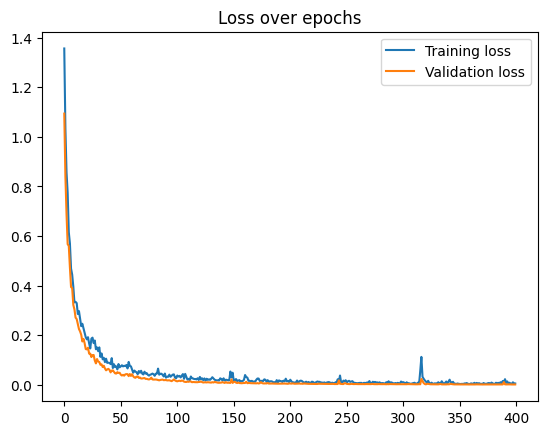

In [56]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()